In [1]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from yahoo_fin import stock_info as si
import datetime as dt
from pyspark.ml import Pipeline
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as F
from pyspark.sql.window import Window

/Users/matteopancini/opt/anaconda3/envs/notensor/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


# Data Collection

In [2]:
ticker = 'TSLA'
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2023, 1, 1)
fred_symbols = ['UNRATE', 'GDP', 'FEDFUNDS', 'CPIAUCNS', 'M2', 'DGS10', 'PCE', 'T10Y2Y', 'USROA', 'USROE', 'WTISPLC', 'HOUST', 'INDPRO', 'PAYEMS', 'BAMLH0A0HYM2', 'GS10', 'BASE', 'RIFSPPFAAD01NB', 'EXUSEU', 'NETEXP']

In [3]:
historical_data = si.get_data(ticker, start_date, end_date, interval='1d')
fred_df = pdr.get_data_fred(fred_symbols, start_date, end_date)

# Data Pre-Processing with Spark

In [4]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("StockPrediction") \
    .config("spark.sql.debug.maxToStringFields", "100") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/28 17:34:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
historical_data_spark = spark.createDataFrame(historical_data.reset_index())
fred_df_spark = spark.createDataFrame(fred_df.reset_index())

In [6]:
historical_data_spark = historical_data_spark.withColumnRenamed("index", "DATE")
historical_data_spark = historical_data_spark.drop('ticker', 'adjclose')

historical_data_spark = historical_data_spark.withColumn("year", year("DATE"))
historical_data_spark = historical_data_spark.withColumn("month", month("DATE"))
historical_data_spark = historical_data_spark.withColumn("day", dayofmonth("DATE"))

#historical_data_spark.show()

In [7]:
fred_df_spark = fred_df_spark.withColumn("Index", monotonically_increasing_id())
#fred_df_spark.show()

In [8]:
dataset_spark = historical_data_spark.join(fred_df_spark, on="DATE", how="left")
dataset_spark = dataset_spark.orderBy("DATE")
dataset_spark = dataset_spark.withColumn("Index", monotonically_increasing_id())
dataset_spark = dataset_spark.drop("DATE")
dataset_spark.show()

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=18441Kb max_used=18512Kb free=112630Kb
 bounds [0x000000010220c000, 0x000000010343c000, 0x000000010a20c000]
 total_blobs=7538 nmethods=6699 adapters=752
 compilation: disabled (not enough contiguous free space left)


+------------------+------------------+------------------+------------------+---------+----+-----+---+------+---------+--------+--------+------+-----+-------+------+-----+-----+-------+-----+-------+--------+------------+----+--------+--------------+------+--------+-----+
|              open|              high|               low|             close|   volume|year|month|day|UNRATE|      GDP|FEDFUNDS|CPIAUCNS|    M2|DGS10|    PCE|T10Y2Y|USROA|USROE|WTISPLC|HOUST| INDPRO|  PAYEMS|BAMLH0A0HYM2|GS10|    BASE|RIFSPPFAAD01NB|EXUSEU|  NETEXP|Index|
+------------------+------------------+------------------+------------------+---------+----+-----+---+------+---------+--------+--------+------+-----+-------+------+-----+-----+-------+-----+-------+--------+------------+----+--------+--------------+------+--------+-----+
|1.2666670083999634|1.6666669845581055|1.1693329811096191|1.5926669836044312|281494500|2010|    6| 29|   NaN|      NaN|     NaN|     NaN|   NaN| 2.97|    NaN|  2.36|  NaN|  NaN|    

In [9]:
# Assuming 'df' is your Spark DataFrame
row_count = dataset_spark.count()

# Print the row count
print("Number of rows in the DataFrame: ", row_count)


Number of rows in the DataFrame:  3150


In [10]:
'''
def stringReplaceFunc(x, y):
    return F.when(x != y, x).otherwise(F.lit(None))

def forwardFillImputer(df, cols=[], partitioner="Index", value='NaN'):
    for c in cols:
        df = df.withColumn(c, F.when(F.col(c) != value, F.col(c)))
        df = df.withColumn(c, F.coalesce(F.col(c), F.last(c, True).over(Window.orderBy(partitioner)), F.lit('0')))
    return df
'''

'\ndef stringReplaceFunc(x, y):\n    return F.when(x != y, x).otherwise(F.lit(None))\n\ndef forwardFillImputer(df, cols=[], partitioner="Index", value=\'NaN\'):\n    for c in cols:\n        df = df.withColumn(c, F.when(F.col(c) != value, F.col(c)))\n        df = df.withColumn(c, F.coalesce(F.col(c), F.last(c, True).over(Window.orderBy(partitioner)), F.lit(\'0\')))\n    return df\n'

In [11]:
def forwardFillImputer(df, cols=[], partitioner="Index", value='NaN'):
    for c in cols:
        # Define the window specification with the partitioner
        window_spec = Window.orderBy(partitioner)
        
        # Replace value with NULL
        df = df.withColumn(c, F.when(F.col(c) != value, F.col(c)).otherwise(F.lit(None)))
        
        # Forward fill using the last non-null value within the partition
        df = df.withColumn(c, F.last(c, True).over(window_spec))
            
    return df

In [12]:
dataset_spark = forwardFillImputer(dataset_spark, cols=[i for i in fred_symbols])
dataset_spark.show()

23/09/28 17:34:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 17:34:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 17:34:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 17:34:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 17:34:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 17:34:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 1

+------------------+------------------+------------------+------------------+---------+----+-----+---+------+---------+--------+--------+------+-----+-------+------+-----+-----+-------+-----+-------+--------+------------+----+--------+--------------+------+--------+-----+
|              open|              high|               low|             close|   volume|year|month|day|UNRATE|      GDP|FEDFUNDS|CPIAUCNS|    M2|DGS10|    PCE|T10Y2Y|USROA|USROE|WTISPLC|HOUST| INDPRO|  PAYEMS|BAMLH0A0HYM2|GS10|    BASE|RIFSPPFAAD01NB|EXUSEU|  NETEXP|Index|
+------------------+------------------+------------------+------------------+---------+----+-----+---+------+---------+--------+--------+------+-----+-------+------+-----+-----+-------+-----+-------+--------+------------+----+--------+--------------+------+--------+-----+
|1.2666670083999634|1.6666669845581055|1.1693329811096191|1.5926669836044312|281494500|2010|    6| 29|  null|     null|    null|    null|  null| 2.97|   null|  2.36| null| null|   n

In [13]:
# Drop rows where 'column1' or 'column2' have null values
dataset_spark = dataset_spark.dropna()

# MLLib

In [14]:
# Prepare data for MLlib
feature_columns = [col_name for col_name in dataset_spark.columns if col_name != 'close']
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# Determine the split point based on the desired ratio
split_ratio = 0.8  # 80% for training, 20% for testing
split_point = int(dataset_spark.count() * split_ratio)

# Split the data into training and testing sets
train_data = dataset_spark.limit(split_point)
test_data = dataset_spark.subtract(train_data)

23/09/28 17:34:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 17:34:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 17:34:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 17:34:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 17:34:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 17:34:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 1

# Linear Regression

In [16]:
lr = LinearRegression(labelCol='close', featuresCol='features')

In [17]:
pipeline = Pipeline(stages=[vector_assembler, lr])

In [18]:
# Linear Regression in Spark
lr_model = pipeline.fit(train_data)

23/09/28 17:35:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 17:35:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 17:35:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 17:35:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 17:35:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 17:35:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/28 1

In [19]:
# Model Evaluation in Spark
lr_predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")

In [ ]:
lr_rmse = evaluator.evaluate(lr_predictions)
lr_rmse

In [24]:
# Convert lr_predictions DataFrame to Pandas DataFrame
predictions_pd = lr_predictions.select("Index", "close", "prediction").toPandas()

# Extract the actual "close" values and timestamp
actual_close = predictions_pd["close"]
dates = predictions_pd["Index"]

# Extract the predicted values
predicted_close = predictions_pd["prediction"]

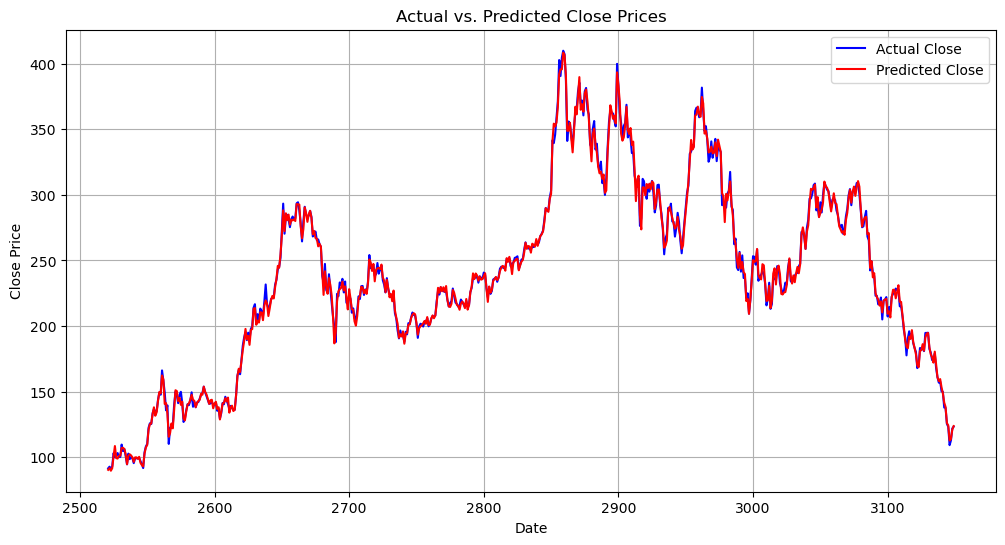

In [25]:
# Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_close, label="Actual Close", color="b")
plt.plot(dates, predicted_close, label="Predicted Close", color="r")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Actual vs. Predicted Close Prices")
plt.legend()
plt.grid(True)
plt.show()